In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import xarray as xr

## Preprocessing

In [2]:
hqprecip = pd.read_csv('HQprecipitation Data.csv')
hqprecip.head()

,time,HqPrecips
0,2001-01-01 00:00:00,"[1.744999885559082, 1.899999976158142, 1.55999..."
1,2001-01-02 00:00:00,"[6.5149993896484375, 3.3349997997283936, 0.779..."
2,2001-01-03 00:00:00,"[1.619999885559082, 1.125, 5.389999866485596, ..."
3,2001-01-04 00:00:00,"[3.509999990463257, 2.6349997520446777, 2.3450..."
4,2001-01-05 00:00:00,"[0.6399999856948853, 0.6349999904632568, 0.140..."


In [3]:
for i in range(3652):
    hqprecip['time'][i] = hqprecip['time'][i][:10]
hqprecip.head()

,time,HqPrecips
0,2001-01-01,"[1.744999885559082, 1.899999976158142, 1.55999..."
1,2001-01-02,"[6.5149993896484375, 3.3349997997283936, 0.779..."
2,2001-01-03,"[1.619999885559082, 1.125, 5.389999866485596, ..."
3,2001-01-04,"[3.509999990463257, 2.6349997520446777, 2.3450..."
4,2001-01-05,"[0.6399999856948853, 0.6349999904632568, 0.140..."


In [4]:
hqprecip['time'] = pd.to_datetime(hqprecip['time'], format='%Y-%m-%d')
hqprecip.head()

,time,HqPrecips
0,2001-01-01,"[1.744999885559082, 1.899999976158142, 1.55999..."
1,2001-01-02,"[6.5149993896484375, 3.3349997997283936, 0.779..."
2,2001-01-03,"[1.619999885559082, 1.125, 5.389999866485596, ..."
3,2001-01-04,"[3.509999990463257, 2.6349997520446777, 2.3450..."
4,2001-01-05,"[0.6399999856948853, 0.6349999904632568, 0.140..."


In [5]:
floods = pd.read_excel('Flood Events Final.xlsx')
floods = floods.drop(columns=['Unnamed: 0'])
floods.head()

,Date,Bernam River,Selangor River,Buloh River,Klang River,Langat River,Sepang River
0,2001-01-25,0,0,0,1,0,0
1,2001-02-19,1,0,0,0,0,0
2,2001-04-03,0,0,0,1,1,0
3,2001-04-09,0,0,0,1,1,0
4,2001-04-13,0,0,0,1,0,0


In [6]:
from datetime import date, timedelta

def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

start_date = date(2001, 1, 1)
end_date = date(2011, 1, 1)
dates = []
for single_date in daterange(start_date, end_date):
    dates.append(single_date.strftime("%Y-%m-%d"))

nonFloods = pd.DataFrame({
    'Date':dates,
    'Bernam River':0,
    'Selangor River':0,
    'Buloh River':0,
    'Klang River':0,
    'Langat River':0,
    'Sepang River':0,
})

nonFloods['Date'] = pd.to_datetime(nonFloods['Date'], format='%Y-%m-%d')
nonFloods.shape

(3652, 7)

In [7]:
floods = floods.append(nonFloods, ignore_index=True)
floods = floods.groupby(['Date']).sum().reset_index()

C:\Users\Hunts\AppData\Local\Temp\ipykernel_19580\3410022939.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  floods = floods.append(nonFloods, ignore_index=True)


In [8]:
result = []
for i in range(3652):
    if 1 in list(floods.iloc[i][1:]):
        result.append(1)
    else:
        result.append(0)

In [9]:
simpleFloods = pd.DataFrame({
    'Date':floods['Date'],
    'Flood':result
})

In [10]:
combined = hqprecip.merge(simpleFloods, left_on='time', right_on='Date')
combined = combined.drop(columns=['time','Date'])
combined.head()
combined.to_excel('HqFloods.xlsx')

In [11]:
hqprecip = hqprecip.drop(columns=['time'])

In [12]:
simpleFloods = simpleFloods.drop(columns=['Date'])

In [13]:
column_list = []
for i in range(225):
    colName = 'HqPrecip_'+str(i)
    column_list.append(colName)

In [14]:
column = []
for i in range(3652):
    values = (hqprecip['HqPrecips'][i])[1:-1].split(', ')
    for j in range(225):
        values[j] = float(values[j])
    column.append(values)

In [16]:
HqSplit = pd.DataFrame(np.column_stack(list(zip(*column))), columns=column_list)

## Simplified Model

This model only predicts whether or not a flood will occur within the entire state of Selangor. A more detailed model will be demonstrated later on.

In [17]:
import imblearn

oversample = imblearn.over_sampling.SMOTE()
HqSplit, simpleFloods = oversample.fit_resample(HqSplit, simpleFloods)

In [18]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(HqSplit, simpleFloods, test_size=0.3, random_state=42)

In [19]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42, class_weight='balanced')
dt.fit(x_train, y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=42)

In [20]:
from sklearn import metrics

dt_predictions = dt.predict(x_test)
cm = metrics.confusion_matrix(y_test,dt_predictions,labels=dt.classes_)

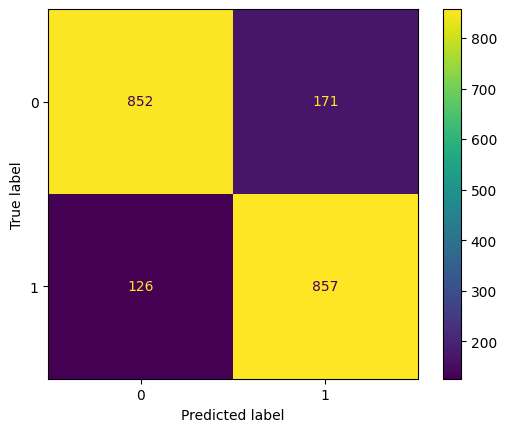

In [21]:
display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt.classes_)
display.plot()
plt.show()

## Full Model

In [22]:
floods = pd.read_excel('Flood Events Final.xlsx')
floods = floods.drop(columns=['Unnamed: 0'])
floods.head()

,Date,Bernam River,Selangor River,Buloh River,Klang River,Langat River,Sepang River
0,2001-01-25,0,0,0,1,0,0
1,2001-02-19,1,0,0,0,0,0
2,2001-04-03,0,0,0,1,1,0
3,2001-04-09,0,0,0,1,1,0
4,2001-04-13,0,0,0,1,0,0


In [23]:
from datetime import date, timedelta

def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

start_date = date(2001, 1, 1)
end_date = date(2011, 1, 1)
dates = []
for single_date in daterange(start_date, end_date):
    dates.append(single_date.strftime("%Y-%m-%d"))

nonFloods = pd.DataFrame({
    'Date':dates,
    'Bernam River':0,
    'Selangor River':0,
    'Buloh River':0,
    'Klang River':0,
    'Langat River':0,
    'Sepang River':0,
})

nonFloods['Date'] = pd.to_datetime(nonFloods['Date'], format='%Y-%m-%d')
nonFloods.shape

(3652, 7)

In [24]:
floods = floods.append(nonFloods, ignore_index=True)
floods = floods.groupby(['Date']).sum().reset_index()

C:\Users\Hunts\AppData\Local\Temp\ipykernel_19580\3410022939.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  floods = floods.append(nonFloods, ignore_index=True)


In [25]:
floodsFixed = []
for i in range(3652):
    floodsFixed.append(np.array(floods.iloc[i]))

In [27]:
hqprecip = pd.read_csv('HQprecipitation Data.csv')

for i in range(3652):
    hqprecip['time'][i] = hqprecip['time'][i][:10]
    
hqprecip['time'] = pd.to_datetime(hqprecip['time'], format='%Y-%m-%d')
hqprecip.head()

,time,HqPrecips
0,2001-01-01,"[1.744999885559082, 1.899999976158142, 1.55999..."
1,2001-01-02,"[6.5149993896484375, 3.3349997997283936, 0.779..."
2,2001-01-03,"[1.619999885559082, 1.125, 5.389999866485596, ..."
3,2001-01-04,"[3.509999990463257, 2.6349997520446777, 2.3450..."
4,2001-01-05,"[0.6399999856948853, 0.6349999904632568, 0.140..."


In [28]:
column_list = []
for i in range(225):
    colName = 'HqPrecip_'+str(i)
    column_list.append(colName)
    
column = []
for i in range(3652):
    values = (hqprecip['HqPrecips'][i])[1:-1].split(', ')
    for j in range(225):
        values[j] = float(values[j])
    column.append(values)

HqSplit = pd.DataFrame(np.column_stack(list(zip(*column))), columns=column_list)

In [29]:
HqFixed = []
for i in range(3652):
    HqFixed.append(np.array(HqSplit.iloc[i]))

In [30]:
floods = floods.drop(columns=['Date'])

In [32]:
X_train, X_test, y_train, y_test = train_test_split(HqSplit, floods, random_state=42)

In [44]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression

multiClf = MultiOutputClassifier(LogisticRegression(max_iter=10000)).fit(X_train,y_train)

In [45]:
multiPredictions = multiClf.predict_proba(X_test)
multiPredictions[0]

array([[2.27269884e-03, 9.97727301e-01],
       [1.00000000e+00, 1.35237192e-10],
       [1.81775802e-03, 9.98182242e-01],
       ...,
       [5.32373874e-05, 9.99946763e-01],
       [9.99942928e-01, 5.70720618e-05],
       [9.99989439e-01, 1.05610782e-05]])

In [46]:
multiScore = multiClf.score(X_test,np.array(y_test))
multiScore

0.9381970513029759

In [43]:
predictions = clf.predict(X_test)
cm = metrics.multilabel_confusion_matrix(y_test,predictions)
print(cm)

[[[13438     3]
  [    0  4940]]

 [[10771     7]
  [    0  7603]]

 [[12504    12]
  [    0  5865]]

 [[ 9996    30]
  [    4  8351]]

 [[10789    34]
  [    0  7558]]

 [[15860     0]
  [    0  2521]]]


### Label Powerset Attempt

In [37]:
floods['powerLabel'] = floods.apply(lambda x: 32*x['Bernam River']+16*x["Selangor River"]+8*x['Buloh River']+4*x['Klang River']+2*x['Langat River']+1*x['Sepang River'],axis=1)

In [38]:
ROS = imblearn.over_sampling.RandomOverSampler(random_state=42)
X_res, y_res = ROS.fit_resample(HqSplit, floods['powerLabel'])

In [39]:
y_res = y_res.fillna(value=0)
y_res

0         0
1         0
2         0
3         0
4         0
         ..
73519    56
73520    56
73521    56
73522    56
73523    56
Name: powerLabel, Length: 73524, dtype: int64

In [40]:
def unpowerLabel(label):
    value = int(bin(int(label))[2:])
    values = [int(x) for x in str(value)]
    while len(values) != 6:
        values.insert(0,0)
    return values

In [41]:
y_unpowered = []
for i in range(len(y_res)):
    y_unpowered.append(unpowerLabel(y_res[i]))

In [42]:
from sklearn.neural_network import MLPClassifier

X_train, X_test, y_train, y_test = train_test_split(X_res, y_unpowered, random_state=42)
clf = MLPClassifier(random_state=42, max_iter=300).fit(X_train, y_train)
clf.score(X_test, y_test)

0.9956476796692236